In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

df = pd.read_csv('organ_embeddings.csv') 
features = df.filter(regex='^dim_').values 
labels = df['label'].values

X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_val_scaled = scaler.transform(X_val_raw)

X_train = torch.FloatTensor(X_train_scaled)
X_val = torch.FloatTensor(X_val_scaled)
y_train = torch.FloatTensor(y_train_raw).view(-1, 1)
y_val = torch.FloatTensor(y_val_raw).view(-1, 1)

ae_loader = DataLoader(TensorDataset(X_train), batch_size=16, shuffle=True)
clf_train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=8, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=8, shuffle=False)

class KidneyAutoencoder(nn.Module):
    def __init__(self):
        super(KidneyAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64) 
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 512)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        return self.decoder(encoded)

class KidneyClassifier(nn.Module):
    def __init__(self, trained_encoder):
        super(KidneyClassifier, self).__init__()
        self.encoder = trained_encoder
        self.classifier_head = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        with torch.no_grad():
            features = self.encoder(x)
        return self.classifier_head(features)

ae_model = KidneyAutoencoder()
criterion_ae = nn.MSELoss()
optimizer_ae = optim.Adam(ae_model.parameters(), lr=0.001)


c:\Users\percy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.4.2)
  from scipy.sparse import csr_matrix, issparse


In [7]:
print("Starting Pre-training...")
ae_losses = []
for epoch in range(100):
    epoch_loss = 0
    for batch in ae_loader:
        inputs = batch[0]
        outputs = ae_model(inputs)
        loss = criterion_ae(outputs, inputs)
        
        optimizer_ae.zero_grad()
        loss.backward()
        optimizer_ae.step()
        epoch_loss += loss.item()
    ae_losses.append(epoch_loss / len(ae_loader))

classifier = KidneyClassifier(ae_model.encoder)
criterion_clf = nn.BCELoss()
optimizer_clf = optim.Adam(classifier.parameters(), lr=0.0005, weight_decay=1e-4)

Starting Pre-training...


Starting Fine-tuning...

Final Validation Accuracy: 0.9935


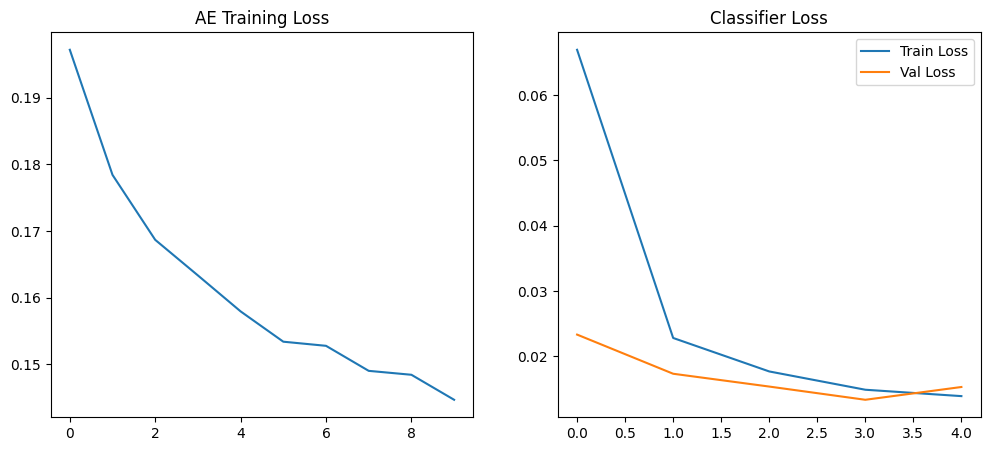

In [6]:
print("Starting Fine-tuning...")
train_clf_losses = []
val_clf_losses = []

for epoch in range(5):
    classifier.train()
    epoch_train_loss = 0
    for inputs, labels in clf_train_loader:
        predictions = classifier(inputs)
        loss = criterion_clf(predictions, labels)
        optimizer_clf.zero_grad()
        loss.backward()
        optimizer_clf.step()
        epoch_train_loss += loss.item()
    
    train_clf_losses.append(epoch_train_loss / len(clf_train_loader))

    classifier.eval()
    val_preds, val_labels_list = [], []
    epoch_val_loss = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = classifier(inputs)
            val_loss = criterion_clf(outputs, labels)
            epoch_val_loss += val_loss.item()
            
            val_preds.extend((outputs > 0.5).float().numpy())
            val_labels_list.extend(labels.numpy())

    val_clf_losses.append(epoch_val_loss / len(val_loader))
    
    if (epoch+1) % 10 == 0:
        acc = accuracy_score(val_labels_list, val_preds)
        prec = precision_score(val_labels_list, val_preds, zero_division=0)
        print(f"Epoch [{epoch+1}/50] | Val Loss: {val_clf_losses[-1]:.4f} | Val Acc: {acc:.4f} | Val Prec: {prec:.4f}")

print(f"\nFinal Validation Accuracy: {accuracy_score(val_labels_list, val_preds):.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(ae_losses)
plt.title('AE Training Loss')

plt.subplot(1, 2, 2)
plt.plot(train_clf_losses, label='Train Loss')
plt.plot(val_clf_losses, label='Val Loss')
plt.title('Classifier Loss')
plt.legend()
plt.show()



In [ ]:
torch.save(classifier.state_dict(), 'kidney_classifier.pth')
import joblib
joblib.dump(scaler, 'data_scaler.pkl')